# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Описание данных

Признаки:  
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя  

Целевой признак:  
* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time


from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('autos.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Посмотрим на количество пропусков в данных.

In [4]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Пропуски имеются в пяти столбцах - Model, Gearbox, VehicleType, FuelType, Repaired

Посмотрим на значения в столбцах с пропусками - значения здесь категориальные, доля пропущенных значений больше или близко к 10%:

In [5]:
df.isnull().sum()/len(df)

DateCrawled          0.000000
Price                0.000000
VehicleType          0.105794
RegistrationYear     0.000000
Gearbox              0.055967
Power                0.000000
Model                0.055606
Kilometer            0.000000
RegistrationMonth    0.000000
FuelType             0.092827
Brand                0.000000
Repaired             0.200791
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

Удалить эти строки мы не можем, поэтому заменим значения заглушкой unknown, так как все столбцы имеют категориальные значения:

In [6]:
df = df.fillna('unknown') 

Проверим данные на наличие дубликатов.

In [7]:
print('Количество дубликатов:', df.duplicated().sum())
df[df.duplicated(keep=False)]

Количество дубликатов: 4


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
41529,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15
88087,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
90964,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
187735,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


В данных содержится 4 дубликата. Их можно удалить.

#### Резюме  
Всего в данных содержится 354369 строк и 16 столбцов.  
  
7 столбцов хранят данные в формате int64, 9 - в формате object.  
  
5 столбцов содержат пропуски. Их количество указано ниже (в долях от общего объема данных):  

* VehicleType: 0.11
* Gearbox: 0.06
* Model: 0.06
* FuelType: 0.09
* NotRepaired: 0.20  

Все столбцы, которые содержат пропуски - категориальные.  

В данных содержится 4 дубликата

Рассмотрим числовые признаки:

In [8]:
df.describe(percentiles=[.12, .25, .5, .75, .999])

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
12%,550.000000,1996.000000,43.000000,70000.000000,1.000000,0.0,18059.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
99.9%,19999.000000,2018.000000,700.000000,150000.000000,12.000000,0.0,99897.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Изучим каждый столбец по отдельности.

Столбец DateCrawled

In [9]:
pd.to_datetime(df.DateCrawled).describe()

count                           354369
mean     2016-03-21 12:58:10.450648320
min                2016-03-05 14:06:22
25%                2016-03-13 11:52:33
50%                2016-03-21 17:50:55
75%                2016-03-29 14:37:20
max                2016-04-07 14:36:58
Name: DateCrawled, dtype: object

Скачивание анкет производилось с 5 марта 2016 года по 7 апреля 2016 года.

Столбец Price

In [10]:
df.Price.describe(percentiles=[.05, .1, .25, .95])

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
5%          200.000000
10%         499.000000
25%        1050.000000
50%        2700.000000
95%       14600.000000
max       20000.000000
Name: Price, dtype: float64

5% объектов имеют стоимость ниже 200 евро.

Text(0.5, 1.0, 'Диаграмма размаха цены')

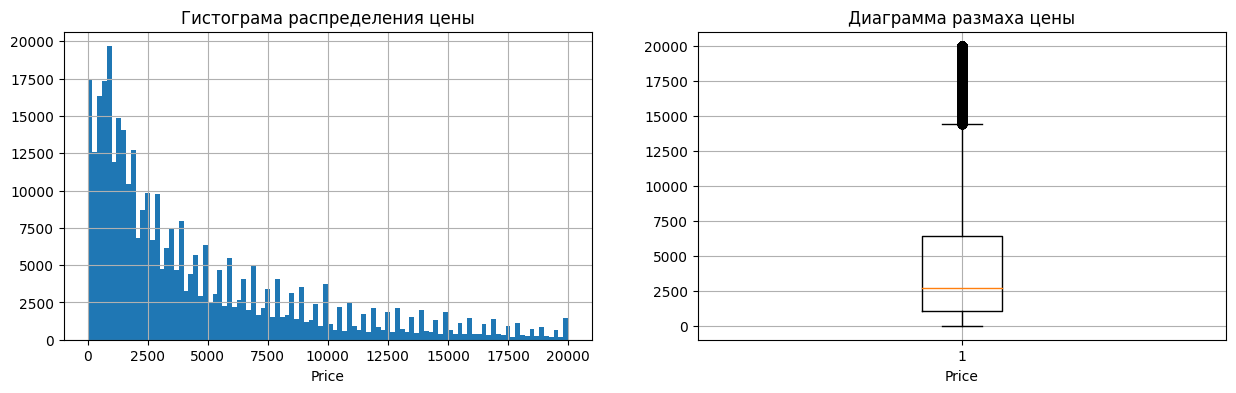

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

ax[0].hist(df.Price, bins=100)
ax[0].grid()
ax[0].set_xlabel('Price')
ax[0].set_title('Гистограма распределения цены')

ax[1].boxplot(df.Price)
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Диаграмма размаха цены')

Есть нулевые и близкие к нулю значения. Посмотрим на их количество.

In [12]:
print('Количество объектов с ценой 0')
df.Price[lambda x: x == 0].count()

Количество объектов с ценой 0


10772

In [13]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (11, 50), (51, 100), (101, 499), (500, 20000)], closed='both')
pd.cut(df.Price, bins).value_counts().sort_index()

Price
[0, 10]          12112
[11, 50]           638
[51, 100]         1595
[101, 499]       21709
[500, 20000]    318315
Name: count, dtype: int64

В данных содержатся 12750 автомобилей с ценой от 0 до 50 евро, и 1595 авто с ценой от 51 до 100 евро.  
  
На основании почтовых индексов, которые содержатся в данных, можно предположить, что эти данные об автомобилях из Германии. По началу, суммы в 10 и 50 евро казались ошибочными, однако как оказалось, на рынке б/у автомобилей Германии действительно есть такие авто. Оставим все как есть.

Столбец VehicleType

Посмотрим на уникальные значения столбца VehicleType

In [14]:
# Фунцкция выводит список уникальных значений категориального столбца и их количество.
def print_unique_values(column):
    print(f'Уникальные значения {column}:')
    display(sorted(list(df.dropna()[column].unique())))
    display(df[column].value_counts(dropna=False))
    print(f'Contains {df[column].isna().sum()} NaN values')

In [15]:
print_unique_values('VehicleType')

Уникальные значения VehicleType:


['bus',
 'convertible',
 'coupe',
 'other',
 'sedan',
 'small',
 'suv',
 'unknown',
 'wagon']

VehicleType
sedan          91457
small          79831
wagon          65166
unknown        37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: count, dtype: int64

Contains 0 NaN values


Посмотрим на среднюю и медианную цену для каждого типа транспорта.

In [16]:
df.groupby('VehicleType', dropna=False)['Price'].agg(['mean', 'median']).round(1).sort_values(by='median')

,mean,median
VehicleType,,
unknown,2375.4,1199.0
small,2677.7,1500.0
other,3563.8,2200.0
sedan,4722.7,2999.0
wagon,4880.3,3200.0
coupe,6010.9,3950.0
bus,5487.1,4200.0
convertible,6807.0,5500.0
suv,9009.2,8500.0


Медианная цена для каждого VehicleType заметно отличается. Вероятно, что между этими переменными есть зависимость.  

Столбец RegistrationYear

In [17]:
df.RegistrationYear.describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [18]:
print_unique_values('RegistrationYear')

Уникальные значения RegistrationYear:


[1000,
 1001,
 1039,
 1111,
 1200,
 1234,
 1253,
 1255,
 1300,
 1400,
 1500,
 1600,
 1602,
 1688,
 1800,
 1910,
 1915,
 1919,
 1920,
 1923,
 1925,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1940,
 1941,
 1942,
 1943,
 1944,
 1945,
 1946,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2222,
 2290,
 2500,
 2800,
 2900,
 3000,
 3200,
 3500,
 3700,
 3800,
 4000,
 4100,
 4500,
 4800,
 5000,
 5300,
 5555,
 5600,
 5900,
 5911,
 6000,
 6500,
 7000,
 7100,
 7500,
 7800,
 8000,
 8200,

RegistrationYear
2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
6500        1
2290        1
1001        1
9450        1
3500        1
Name: count, Length: 151, dtype: int64

Contains 0 NaN values


In [19]:
bins = pd.IntervalIndex.from_tuples([(1000, 1800), (1801, 1900), (1901, 1950), (1951, 2000), (2001, 2016), (2017, 9999)], closed='both')
pd.cut(df.RegistrationYear, bins).value_counts().sort_index()

RegistrationYear
[1000, 1800]        66
[1801, 1900]         0
[1901, 1950]       198
[1951, 2000]    126479
[2001, 2016]    213096
[2017, 9999]     14530
Name: count, dtype: int64

Присоеденим столбец с интревалами по годам и посмотрим на среднюю и медианную цену для каждого года.

,mean,median
RegistrationYear_interval,,
"[1000, 1800]",1442.878788,400.0
"[1801, 1900]",NaN,NaN
"[1901, 1950]",4294.702020,425.0
"[1951, 2000]",1800.777299,1000.0
"[2001, 2016]",6056.512825,4700.0
"[2017, 9999]",3152.201996,1900.0


Text(0.5, 1.0, 'Зависимость цена от даты регистрации')

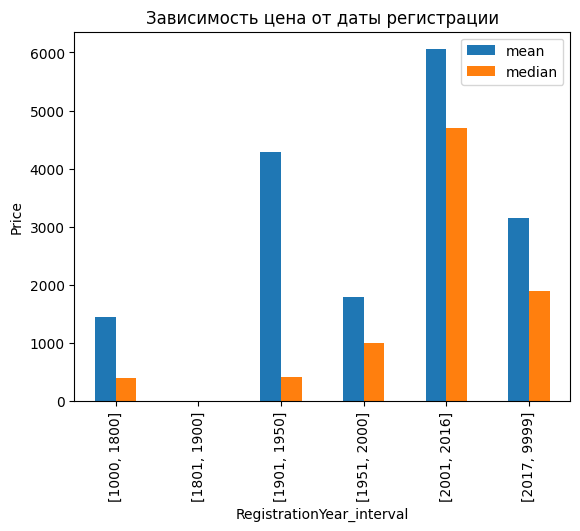

In [20]:
display(
    df.join(pd.cut(df.RegistrationYear, bins), rsuffix='_interval')
    .groupby('RegistrationYear_interval')['Price']
    .agg(['mean', 'median'])
)

(
    df.join(pd.cut(df.RegistrationYear, bins), rsuffix='_interval')
    .groupby('RegistrationYear_interval')['Price']
    .agg(['mean', 'median']).plot.bar()
)
plt.ylabel('Price')
plt.title('Зависимость цена от даты регистрации')

В целом, если убрать из внимания два крайних интервала, то логика в ценообразовании присутствует. С 1901 по 1950 года могу присутсвовать раритетные автомобили, стоимость которых высока (из-за чего срендняя цена равна 4294 евро), однако судя по всему большинство авто в этом интервале устарели и медианная цена их равна 425 евро.
Цена же с 1951 по 2000 года ниже, чем с 2001 по 2016, так как в последний интревал попадают более новые автомобили.  


Столбец Gearbox

In [21]:
print_unique_values('Gearbox')

Уникальные значения Gearbox:


['auto', 'manual', 'unknown']

Gearbox
manual     268251
auto        66285
unknown     19833
Name: count, dtype: int64

Contains 0 NaN values


Посмотрим на среднюю и медианную цену для каждого типа коробки передач.

In [22]:
df.groupby('Gearbox', dropna=False)['Price'].agg(['mean', 'median']).round(1).sort_values(by='median')

,mean,median
Gearbox,,
unknown,2206.3,1000.0
manual,3980.8,2490.0
auto,6842.1,5500.0


Судя по всему автомобили с автоматической коробкой передач в среднем дороже, чем с ручной.

Столбец Power

In [23]:
print('Количество объектов с количеством лошадинных сил равными 0')
df.Power[lambda x: x==0].count()

Количество объектов с количеством лошадинных сил равными 0


40225

In [24]:
df.Power.describe(percentiles=[.1, .25, .75, .95, .99, .999])

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
10%           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
95%         218.000000
99%         300.000000
99.9%       700.000000
max       20000.000000
Name: Power, dtype: float64

Text(0.5, 1.0, 'Гистограмма мощности авто')

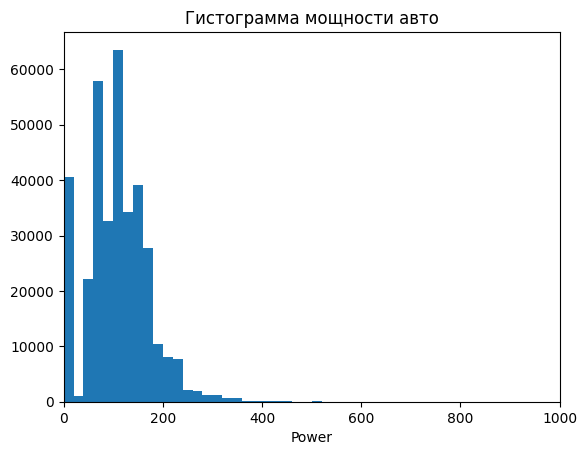

In [25]:
plt.hist(df['Power'], bins = 1000)
plt.xlim(0, 1000)
plt.xlabel('Power')
plt.title('Гистограмма мощности авто')

Посмотрим на описание авто с мощностью равной нулю.

In [26]:
df[df.Power == 0].describe(include='all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,40225,40225.000000,40225,40225.000000,40225,40225.0,40225,40225.000000,40225.000000,40225,40225,40225,40225,40225.0,40225.000000,40225
unique,38924,NaN,9,NaN,3,NaN,248,NaN,NaN,8,40,3,62,NaN,NaN,34697
top,2016-03-24 15:50:18,NaN,unknown,NaN,manual,NaN,unknown,NaN,NaN,petrol,volkswagen,unknown,2016-03-21 00:00:00,NaN,NaN,2016-04-06 00:17:50
freq,3,NaN,14628,NaN,22138,NaN,6294,NaN,NaN,19974,8191,21415,1509,NaN,NaN,6
mean,NaN,2171.864562,NaN,2010.061778,NaN,0.0,NaN,126035.922933,4.002809,NaN,NaN,NaN,NaN,0.0,46500.854941,NaN
std,NaN,3045.863549,NaN,248.317299,NaN,0.0,NaN,45350.959241,4.112125,NaN,NaN,NaN,NaN,0.0,25330.409996,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.0,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,400.000000,NaN,1998.000000,NaN,0.0,NaN,125000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,26607.000000,NaN
50%,NaN,1050.000000,NaN,2001.000000,NaN,0.0,NaN,150000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,45473.000000,NaN
75%,NaN,2600.000000,NaN,2007.000000,NaN,0.0,NaN,150000.000000,7.000000,NaN,NaN,NaN,NaN,0.0,65428.000000,NaN


Поделим мощность на интервалы и посмотрим сколько авто в ходит в каждый интервал.

In [27]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (11, 43), (51, 700), (701, 20000)], closed='both')
pd.cut(df.Power, bins, duplicates='drop').value_counts().sort_index()


Power
[0, 10]          40460
[11, 43]          2122
[51, 700]       303216
[701, 20000]       354
Name: count, dtype: int64

Всего 354 из 354369 содержат значения свыше 700 лошадинных сил.

Посмотрим на график разброса цены и количества лошадинных сил.

Text(0.5, 1.0, 'Лошадинные силы / Цена (без выбросов в Power)')

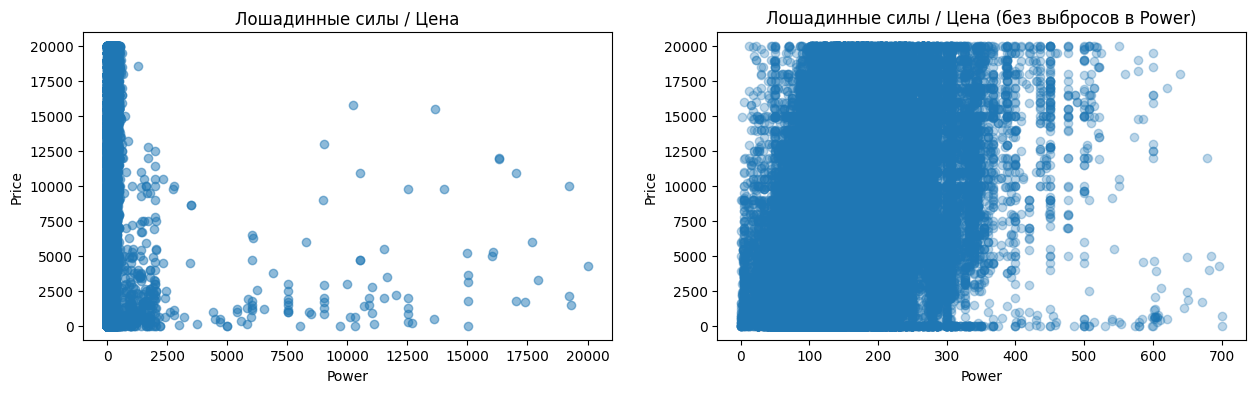

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (15,4))

ax[0].scatter(df.Power, df.Price, alpha = 0.5)
ax[0].set_xlabel('Power')
ax[0].set_ylabel('Price')
ax[0].set_title('Лошадинные силы / Цена')

ax[1].scatter(df[(df.Power <701) & (df.Power != 0)].Power, df[(df.Power <701) & (df.Power != 0)].Price, alpha = 0.3)
ax[1].set_xlabel('Power')
ax[1].set_ylabel('Price')
ax[1].set_title('Лошадинные силы / Цена (без выбросов в Power)')

In [29]:
print('Коэффициент корреляции (с выбросами в столбце Power)', df.Power.corr(df.Price).round(2))
print('Коэффициент корреляции (без выбросов в столбце Power)',df[(df.Power <701) & (df.Power != 0)].Power.corr(df[(df.Power <701) & (df.Power != 0)].Price).round(2))

Коэффициент корреляции (с выбросами в столбце Power) 0.16
Коэффициент корреляции (без выбросов в столбце Power) 0.49


Столбец Model

In [30]:
df.Model.nunique()

251

In [31]:
print_unique_values('Model')

Уникальные значения Model:


['100',
 '145',
 '147',
 '156',
 '159',
 '1_reihe',
 '1er',
 '200',
 '2_reihe',
 '300c',
 '3_reihe',
 '3er',
 '4_reihe',
 '500',
 '5_reihe',
 '5er',
 '601',
 '6_reihe',
 '6er',
 '7er',
 '80',
 '850',
 '90',
 '900',
 '9000',
 '911',
 'a1',
 'a2',
 'a3',
 'a4',
 'a5',
 'a6',
 'a8',
 'a_klasse',
 'accord',
 'agila',
 'alhambra',
 'almera',
 'altea',
 'amarok',
 'antara',
 'arosa',
 'astra',
 'auris',
 'avensis',
 'aveo',
 'aygo',
 'b_klasse',
 'b_max',
 'beetle',
 'berlingo',
 'bora',
 'boxster',
 'bravo',
 'c1',
 'c2',
 'c3',
 'c4',
 'c5',
 'c_klasse',
 'c_max',
 'c_reihe',
 'caddy',
 'calibra',
 'captiva',
 'carisma',
 'carnival',
 'cayenne',
 'cc',
 'ceed',
 'charade',
 'cherokee',
 'citigo',
 'civic',
 'cl',
 'clio',
 'clk',
 'clubman',
 'colt',
 'combo',
 'cooper',
 'cordoba',
 'corolla',
 'corsa',
 'cr_reihe',
 'croma',
 'crossfire',
 'cuore',
 'cx_reihe',
 'defender',
 'delta',
 'discovery',
 'doblo',
 'ducato',
 'duster',
 'e_klasse',
 'elefantino',
 'eos',
 'escort',
 'espace',
 

Model
golf                  29232
other                 24421
3er                   19761
unknown               19705
polo                  13066
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 251, dtype: int64

Contains 0 NaN values


Столбец Kilometer

In [32]:
df.Kilometer.describe()

count    354369.000000
mean     128211.172535
std       37905.341530
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64

In [33]:
df.Kilometer.nunique()

13

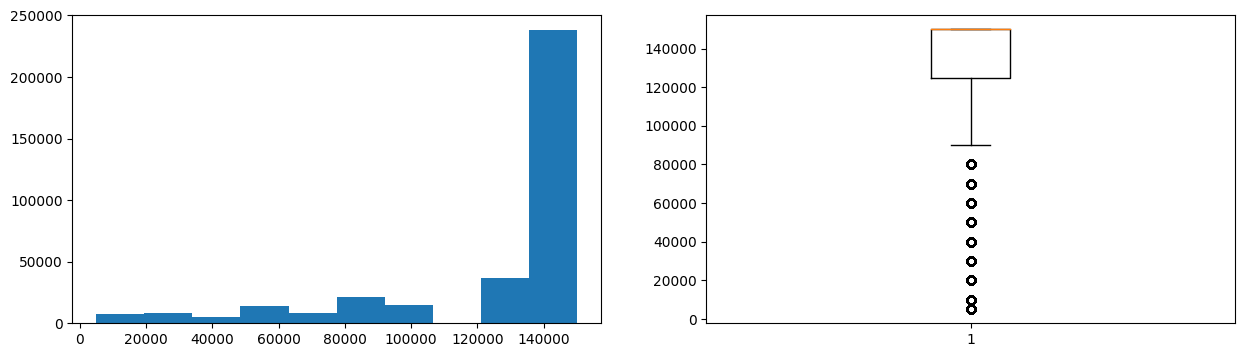

In [34]:
fig, ax = plt.subplots(1 ,2 , figsize = (15,4))

ax[0].hist( df.Kilometer,bins=10)
ax[1].boxplot(df.Kilometer)
plt.show()

У нас всего 13 уникальных значений пробега. Мы можем проанализировать этот признак как категориальный. Посмотрим на среднюю стоимость автомобиля для каждого значения пробега.

Text(0.5, 1.0, 'Медианная цена в зависимости от пробега')

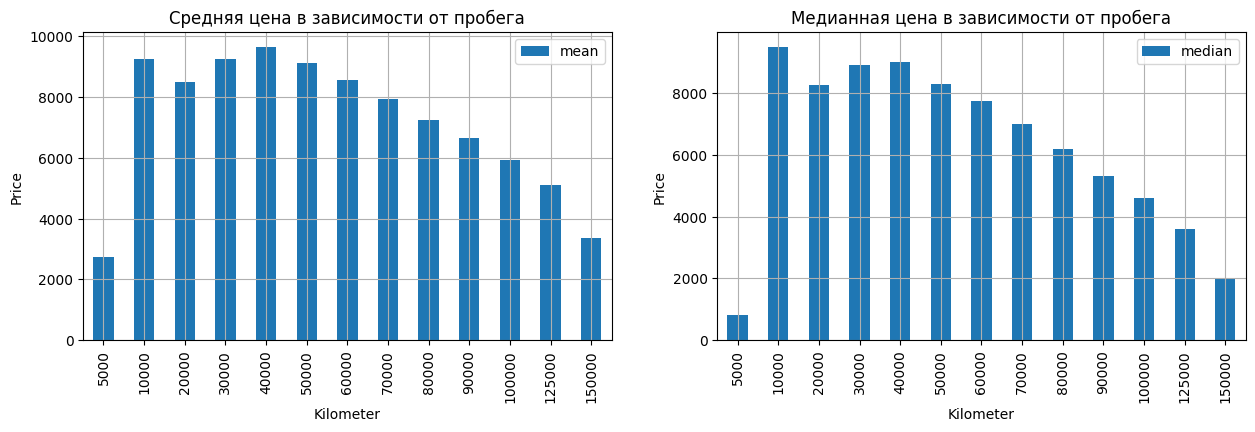

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

df.groupby('Kilometer')['Price'].agg(['mean']).plot.bar(ax=ax[0])
ax[0].set_xlabel('Kilometer')
ax[0].set_ylabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от пробега');

df.groupby('Kilometer')['Price'].agg(['median']).plot.bar(ax=ax[1])
ax[1].set_xlabel('Kilometer')
ax[1].set_ylabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от пробега')

В целом картина логична - чем выше пробег, тем ниже средняя цена на авто. Удивляет лишь то, что авто с пробегом 5000 км стоят так дешево. Видимо причина в чем-то ином. Можно предположить, что они битые, либо у них есть еще какие-либо неполадки, из-за чего их выставили на продажу с таким небольшим пробегом и такой, относительно низкой ценой. Но это лишь предположение.

Столбец RegistrationMonth

<Axes: ylabel='RegistrationMonth'>

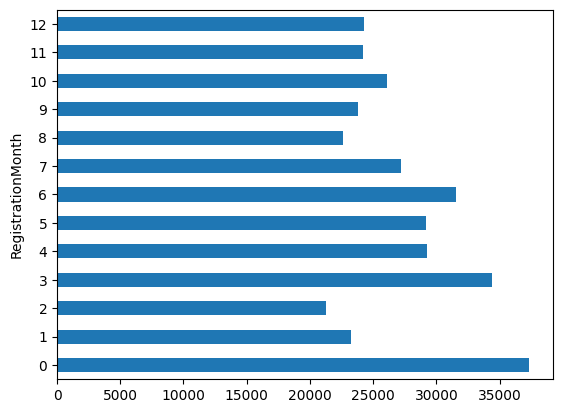

In [36]:
# Посмотрим на количество уникальных значений каждого номера месяца.
df.RegistrationMonth.value_counts().sort_index().plot.barh()

Не совсем понятно, почему всего 13 уникальных значений, а не 12 (разве что летоисчесление велось по лунно-солнечному еврейскому календарю, в котором переодически добавляется 13-й високосный месяц :)  
Однако, конечно, наиболее вероятно, что 0 - это незаполненное значение.  
Так или иначе мы не будем использовать этот столбец в качестве признака, поэтому не будем уделять ему много внимания и пойдем дальше.

Столбец FuelType

In [37]:
print_unique_values('FuelType')

Уникальные значения FuelType:


['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol', 'unknown']

FuelType
petrol      216352
gasoline     98720
unknown      32895
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

Contains 0 NaN values


Посмотрим на среднюю ценю для авто на каждом из видов топливной системы.

Text(0.5, 1.0, 'Медианная цена в зависимости от типа топливной системы')

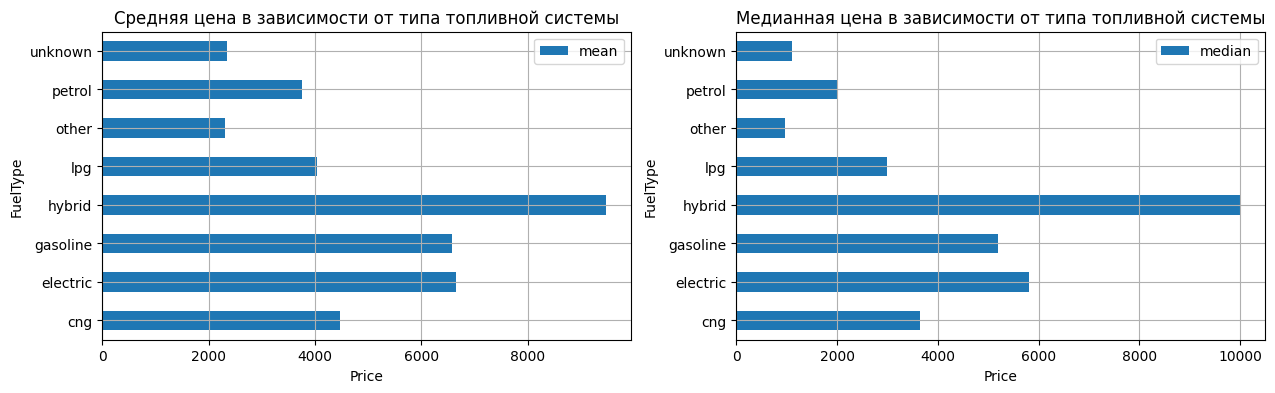

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

df.groupby('FuelType', dropna=False)['Price'].agg(['mean']).plot.barh(ax=ax[0])
ax[0].set_xlabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от типа топливной системы')

df.groupby('FuelType', dropna=False)['Price'].agg(['median']).plot.barh(ax=ax[1])
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от типа топливной системы')

Исходя их графиков можно предположить, что цена на автомобиль в определенной степени зависит от типа топливной системы.  

Можно также заметить, что 'petrol' и 'gasoline' - это британское и американское название бензина. Однако, не смотря на то, что это синонимы - средняя цена у данных видов топлива различается значительно.  

Может быть у различных марок авто указана различная топливная система, в зависимости от страны производителя?

<Axes: title={'center': 'Бренд регистрации у автомобилей с топливом Gasoline'}, xlabel='Бренд авто', ylabel='Количество авто'>

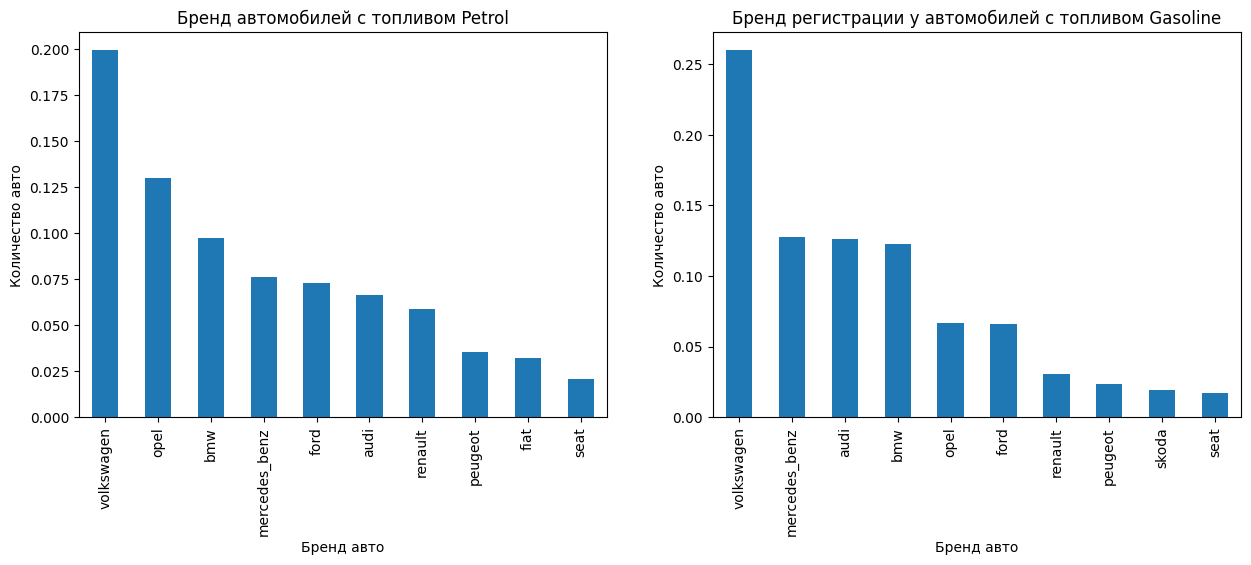

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

(
df[df['FuelType'] == 'petrol'].Brand.value_counts(normalize=True)[:10]
                                .plot.bar(title='Бренд автомобилей с топливом Petrol', ax=ax[0], ylabel='Количество авто', xlabel='Бренд авто')
)
(
df[df['FuelType'] == 'gasoline'].Brand.value_counts(normalize=True)[:10]
                                .plot.bar(title='Бренд регистрации у автомобилей с топливом Gasoline', ax=ax[1], ylabel='Количество авто', xlabel='Бренд авто')
)

Разницы практически нет. И там и там в топе немецкие авто.  



Столбец Brand

In [40]:
print_unique_values('Brand')

Уникальные значения Brand:


['alfa_romeo',
 'audi',
 'bmw',
 'chevrolet',
 'chrysler',
 'citroen',
 'dacia',
 'daewoo',
 'daihatsu',
 'fiat',
 'ford',
 'honda',
 'hyundai',
 'jaguar',
 'jeep',
 'kia',
 'lada',
 'lancia',
 'land_rover',
 'mazda',
 'mercedes_benz',
 'mini',
 'mitsubishi',
 'nissan',
 'opel',
 'peugeot',
 'porsche',
 'renault',
 'rover',
 'saab',
 'seat',
 'skoda',
 'smart',
 'sonstige_autos',
 'subaru',
 'suzuki',
 'toyota',
 'trabant',
 'volkswagen',
 'volvo']

Brand
volkswagen        77013
opel              39931
bmw               36914
mercedes_benz     32046
audi              29456
ford              25179
renault           17927
peugeot           10998
fiat               9643
seat               6907
mazda              5615
skoda              5500
smart              5246
citroen            5148
nissan             4941
toyota             4606
hyundai            3587
sonstige_autos     3374
volvo              3210
mini               3202
mitsubishi         3022
honda              2817
kia                2465
suzuki             2323
alfa_romeo         2314
chevrolet          1754
chrysler           1439
dacia               900
daihatsu            806
subaru              762
porsche             758
jeep                677
trabant             589
land_rover          545
daewoo              542
saab                526
jaguar              505
rover               486
lancia              471
lada                225
Name: count, dtype: int64

Contains 0 NaN values


Посмотрим на среднюю цену авто для каждой модели.

Text(0.5, 1.0, 'Медианная цена в зависимости от марки автомобиля')

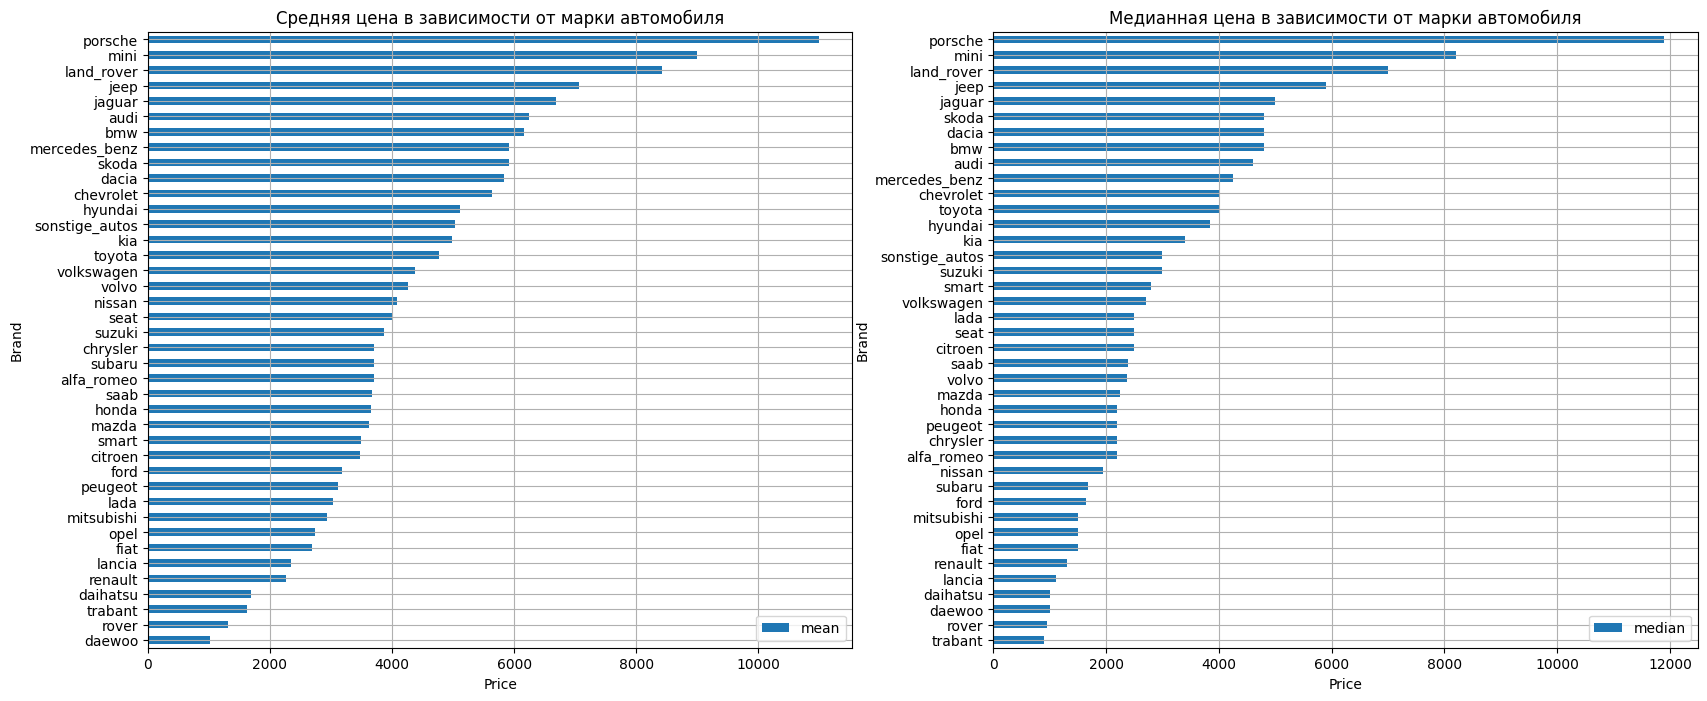

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

df.groupby('Brand')['Price'].agg(['mean']).sort_values(by='mean').plot.barh(ax=ax[0])
ax[0].set_xlabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от марки автомобиля')

df.groupby('Brand')['Price'].agg(['median']).sort_values(by='median').plot.barh(ax=ax[1])
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от марки автомобиля')

Очевидно, что марка автомобиля действительно влияет на его стоимость

Столбец Repaired

In [42]:
print_unique_values('Repaired')

Уникальные значения Repaired:


['no', 'unknown', 'yes']

Repaired
no         247161
unknown     71154
yes         36054
Name: count, dtype: int64

Contains 0 NaN values


Text(0.5, 1.0, 'Медианная цена в зависимости от того, был ли автомобиль в ремонте')

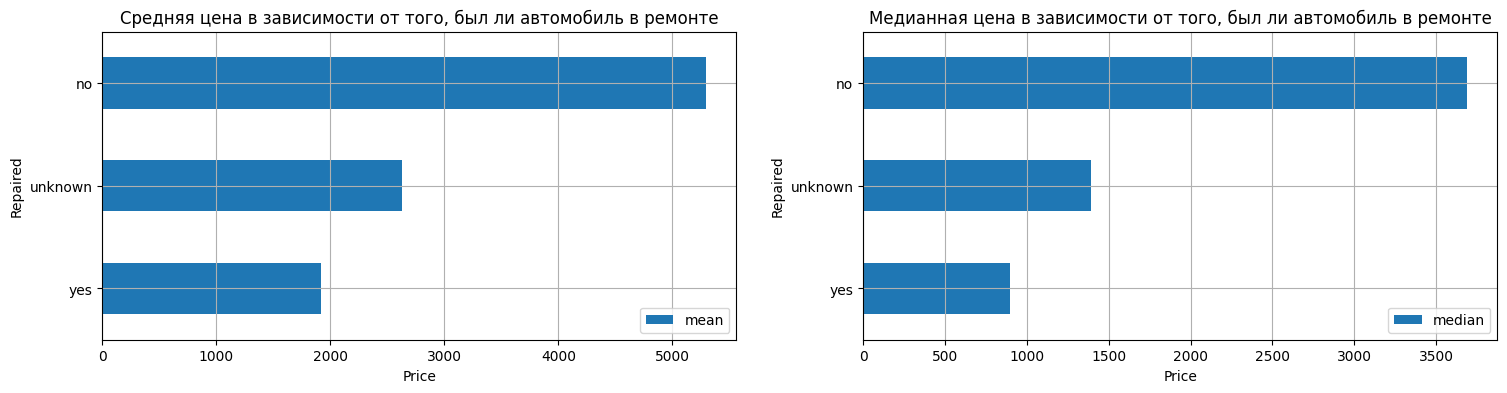

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

df.groupby('Repaired', dropna=False)['Price'].agg(['mean']).sort_values(by='mean').plot.barh(ax=ax[0])
ax[0].set_xlabel('Price')
ax[0].grid()
ax[0].set_title('Средняя цена в зависимости от того, был ли автомобиль в ремонте')

df.groupby('Repaired', dropna=False)['Price'].agg(['median']).sort_values(by='median').plot.barh(ax=ax[1])
ax[1].set_xlabel('Price')
ax[1].grid()
ax[1].set_title('Медианная цена в зависимости от того, был ли автомобиль в ремонте')

"yes": "был в ремонте"  
"no": "не был в ремонте"


Столбец DateCreated

In [44]:
pd.to_datetime(df.DateCreated).describe()

count                           354369
mean     2016-03-20 19:12:07.753274112
min                2014-03-10 00:00:00
25%                2016-03-13 00:00:00
50%                2016-03-21 00:00:00
75%                2016-03-29 00:00:00
max                2016-04-07 00:00:00
Name: DateCreated, dtype: object

Удивительно, что все выгруженные объвления - без фотографий. Возможно, ошибка выгрузки.

Столбец PostalCode

In [45]:
df.PostalCode.describe()

count    354369.000000
mean      50508.689087
std       25783.096248
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: PostalCode, dtype: float64

Столбец LastSeen

In [46]:
pd.to_datetime(df.LastSeen).describe()

count                           354369
mean     2016-03-29 23:51:00.667456768
min                2016-03-05 14:15:08
25%                2016-03-23 02:50:03
50%                2016-04-03 15:15:51
75%                2016-04-06 10:15:19
max                2016-04-07 14:58:51
Name: LastSeen, dtype: object

Последняя активность пользователей находится в промежутке с 5 марта 2016 года по 7 апреля 2016 года.

### Корреляция

In [47]:
categorial_tmp = ['FuelType', 'Repaired', 'Gearbox']

df_tmp = pd.get_dummies(df[categorial_tmp], drop_first=True)

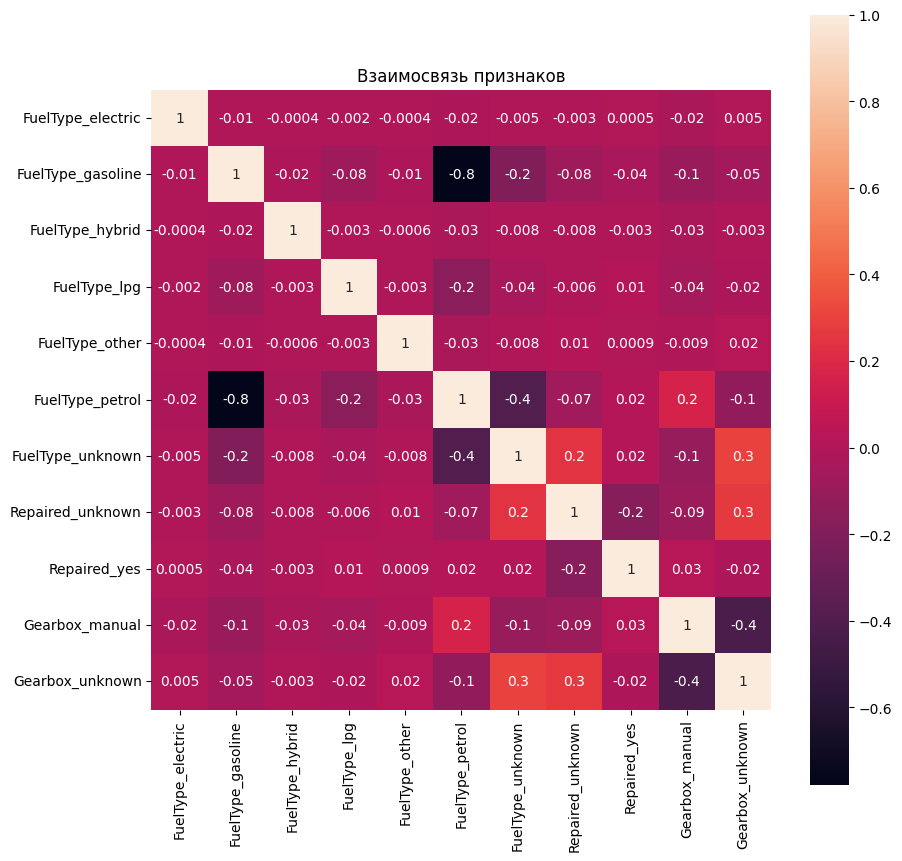

In [48]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df_tmp.corr(),annot = True, fmt = '.1g', ax=ax, square=True)
plt.title('Взаимосвязь признаков')
plt.show() 

В наибольшей степени на целевой признак влияют: год регистрации, мощность, и вид топлива gasoline, а также пробег.  

Так же видим сильную обратную корреляцию между типами топлива petrol и gasoline, что по сути есть один вид топлива - бензин.

Удалим столбцы, не имеющие значения для исследования - datecrawled, datecreated и lastseen, postalcode, numberofpictures(заполнен нулями),registrationmonth(значение имеет только год регистрации):

In [49]:
columns = [
    'DateCrawled', 
    'LastSeen', 
    'PostalCode', 
    'NumberOfPictures', 
    'RegistrationMonth',
    'DateCreated'
    ]
df = df.drop(columns, axis=1)

## Обучение моделей

### Разделение на выборки  
Создадим фиктивные признаки для оставшихся категориальных переменных:  

Разделим исходные данные на обучающую и тестовую выборки - выделим под обучающую 80% и 20% на тестовую.

In [50]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state=123)

Определим признаки:

In [51]:
feature_test = df_test.drop(['Price'], axis = 1)
target_test = df_test['Price']

feature_train = df_train.drop(['Price'], axis = 1)
target_train = df_train['Price']

In [52]:
categorial = ['FuelType', 'Repaired', 'Gearbox', 'VehicleType', 'Brand', 'Model']

tmp_train = feature_train[categorial]
tmp_test= feature_test[categorial]


encoder_ohe = OneHotEncoder(handle_unknown='ignore')
encoder_ohe.fit(feature_train[categorial])

tmp_train = pd.DataFrame(encoder_ohe.transform(feature_train[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=feature_train.index)
tmp_test = pd.DataFrame(encoder_ohe.transform(feature_test[categorial]).toarray(), 
                                   columns=encoder_ohe.get_feature_names_out(),
                                   index=feature_test.index)

feature_train.drop(categorial, axis=1, inplace=True)
feature_train = feature_train.join(tmp_train)

feature_test.drop(categorial, axis=1, inplace=True)
feature_test = feature_test.join(tmp_test)

Проведём масштабирование признаков:

In [53]:
numeric = ['Power', 'Kilometer', 'RegistrationYear']

scaler = StandardScaler()
scaler.fit(df_train[numeric])
feature_train[numeric] = scaler.transform(df_train[numeric])
feature_test[numeric] = scaler.transform(df_test[numeric])

pd.options.mode.chained_assignment = None
feature_train.head(3)

,RegistrationYear,Power,Kilometer,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,...,Model_wrangler,Model_x_reihe,Model_x_trail,Model_x_type,Model_xc_reihe,Model_yaris,Model_yeti,Model_ypsilon,Model_z_reihe,Model_zafira
16178,-0.056844,0.204995,0.575094,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213726,0.052313,-0.006540,0.575094,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46459,0.008650,0.344299,0.575094,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Линейная регрессия

In [54]:
model = LinearRegression()
curr_time = time.time()
model.fit(feature_train, target_train)
fit_time_linear = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(feature_test)

predict_time_linear = round((time.time() - curr_time), 3)
rmse_linear = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_linear)
print('Время обучения:', fit_time_linear)
print('Время предсказания:', predict_time_linear)

RMSE: 3149.176
Время обучения: 16.281
Время предсказания: 0.176


### LightGBM

In [55]:
# param_grid = {
#     'max_depth': [i for i in range(5, 36)],
#     'n_estimators': [i for i in range(0, 5000, 200)],
#     'learning_rate': [i for i in np.arange(0.01, 0.1, 0.03)],
#     'num_leaves': [i for i in range(50, 150, 10)]
# }
# model = LGBMRegressor(random_state=123)
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, random_state=123)
# random_search.fit(feature_train, target_train)
# print("Наилучшие параметры:", random_search.best_params_)

In [56]:
model = LGBMRegressor(
    boosting_type='gbdt', 
    random_state=12345, 
    max_depth=31, 
    n_estimators=3000,
    learning_rate = 0.03,
    num_leaves = 100)
curr_time = time.time()
model.fit(feature_train, target_train)
fit_time_lgbm = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(feature_test)
predict_time_lgbm = round((time.time() - curr_time), 3)
rmse_lgbm = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_lgbm)
print('Время обучения:', fit_time_lgbm)
print('Время предсказания:', predict_time_lgbm)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 968
[LightGBM] [Info] Number of data points in the train set: 283495, number of used features: 303
[LightGBM] [Info] Start training from score 4418.538281
RMSE: 1639.671
Время обучения: 30.132
Время предсказания: 5.602


### Дерево решений  
C помощью RandomizedSearchCV подберем наилучшие параметры:

In [57]:
# param_grid = {
#     'max_depth': [i for i in range(1,16,1)],
# }
# model = DecisionTreeRegressor(random_state=123)
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, random_state=123)
# random_search.fit(feature_train, target_train)
# print("Наилучшие параметры:", random_search.best_params_)

Наилучшие параметры: {'max_depth': 12}


In [68]:
model = DecisionTreeRegressor(max_depth=17, random_state=12345)
curr_time = time.time()
model.fit(feature_train, target_train)
fit_time_dt = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(feature_test)
predict_time_dt = round((time.time() - curr_time), 3)
rmse_dt = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_dt)
print('Время обучения:', fit_time_dt)
print('Время предсказания:', predict_time_dt)

RMSE: 1984.371
Время обучения: 11.122
Время предсказания: 0.191


### Модель случайного леса

In [ ]:
# param_grid = {
#     'max_depth': [i for i in range(1, 16, 3)],
#     'n_estimators': [i for i in range(1, 100, 10)]
# }
# model = RandomForestRegressor(random_state=123)
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, random_state=123)
# random_search.fit(feature_train, target_train)
# print("Наилучшие параметры:", random_search.best_params_)

In [60]:
model = RandomForestRegressor(n_estimators=70, max_depth=13, random_state=12345)
curr_time = time.time()
model.fit(feature_train, target_train)
fit_time_rf = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(feature_test)
predict_time_rf = round((time.time() - curr_time), 3)
rmse_rf = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_rf)
print('Время обучения:', fit_time_rf)
print('Время предсказания:', predict_time_rf)

RMSE: 1870.851
Время обучения: 458.786
Время предсказания: 1.095


### CatBoost

In [ ]:
# param_grid = {
#     'depth': [i for i in range(1,16,3)],
#     'n_estimators' : [i for i in range(1,1401,100)],
#     'learning_rate': [i for i in np.arange(0.1, 1, 0.1)]
# }
# model = CatBoostRegressor(random_state=123)
# random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, random_state=123)
# random_search.fit(feature_train, target_train)
# print("Наилучшие параметры:", random_search.best_params_)

In [61]:
model = CatBoostRegressor(depth=9, n_estimators=1000, random_seed=123, learning_rate=0.55, verbose=100)
model.fit(feature_train, target_train)
fit_time_cb = round((time.time() - curr_time), 3)
curr_time = time.time()
predicted_test = model.predict(feature_test)
predict_time_cb = round((time.time() - curr_time), 3)
rmse_cb = round(mean_squared_error(target_test, predicted_test)**0.5, 3)

print('RMSE:', rmse_cb)
print('Время обучения:', fit_time_cb)
print('Время предсказания:', predict_time_cb)

0:	learn: 3042.5175481	total: 204ms	remaining: 3m 23s
100:	learn: 1666.5464071	total: 3.69s	remaining: 32.8s
200:	learn: 1576.8577011	total: 7.16s	remaining: 28.5s
300:	learn: 1516.6094714	total: 10.8s	remaining: 25s
400:	learn: 1471.1262074	total: 14.3s	remaining: 21.4s
500:	learn: 1433.8011560	total: 17.9s	remaining: 17.8s
600:	learn: 1400.8144728	total: 21.4s	remaining: 14.2s
700:	learn: 1376.5368402	total: 24.9s	remaining: 10.6s
800:	learn: 1353.0669632	total: 28.6s	remaining: 7.1s
900:	learn: 1334.1179336	total: 32.1s	remaining: 3.52s
999:	learn: 1315.9838208	total: 35.7s	remaining: 0us
RMSE: 1674.221
Время обучения: 39.807
Время предсказания: 0.321


## Анализ моделей

Объединим полученные результаты в одну таблицу:

In [69]:
results = pd.DataFrame([
    [rmse_linear, fit_time_linear, predict_time_linear],
    [rmse_lgbm, fit_time_lgbm, predict_time_lgbm],
    [rmse_dt, fit_time_dt, predict_time_dt],
    [rmse_rf, fit_time_rf, predict_time_rf],
    [rmse_cb, fit_time_cb, predict_time_cb]], 
    columns=['RMSE', 'Время обучения', 'Время предсказания'],
    index=['LinearRegression','LightGBM', 'DecisionTree', 'RandomForest', 'CatBoost'])

In [70]:
results.sort_values(by='RMSE')

,RMSE,Время обучения,Время предсказания
LightGBM,1639.671,30.132,5.602
CatBoost,1674.221,39.807,0.321
RandomForest,1870.851,458.786,1.095
DecisionTree,1984.371,11.122,0.191
LinearRegression,3149.176,16.281,0.176


По результатам исследования можно сделать вывод, что лучшими моделями для решения задачи являются LightGBM и CatBoost, причем CatBoost показывает наилучшее соотношение качества/скорости.

Модель DecisionTree показывает лучший результат по скорости обучения и предсказания, но проигрывает по качеству, однако укладывается в заданное значение RMSE < 2500.  

Модель линейной регрессии показывает худшее значение, и не укладывается в заданное значение RMSE.  

Таким образом, если в решении задачи заказчику важнее точность модели, то лучшим решением будет выбор LightGBM. Если важнее скорость обучения и предсказания - то подойдет более простая модель решающего дерева.  